<a href="https://colab.research.google.com/github/Mia-Tay/collab_housing/blob/main/housing_price_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
folder= 'drive/My Drive/learning/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", False)

1, API listings processing


In [ ]:
#open excel file demographics
df = pd.read_csv(folder+'toronto_list.csv').copy()
df.head()

,id,type,status,price,square-footage-min,square-footage-max,bedrooms,bathrooms,location,postal-code,city,unit-number,street-number,street-name,sold-price,style-name
0,10745681,listings,not_available_sold,1750000.0,none,none,3,3,"('-79.342058,43.6778809',)",M4J1J2,Toronto,NaN,72,Harcourt Ave,1700000.0,house-detached
1,10745367,listings,not_available_sold,899000.0,1500,2000,3,4,"('-79.291248,43.8013067',)",M1S4E7,Toronto,NaN,79,Bellefontaine St,950000.0,house-semidetached
2,10726169,listings,not_available_sold,599900.0,1000,1199,3,2,"('-79.30174869999999,43.7190266',)",M4A2S2,Toronto,1402,25,Sunrise Ave,578000.0,condo-highrise
3,10724616,listings,not_available_sold,499000.0,1000,1199,2,2,"('-79.5885685,43.7590096',)",M9V5E3,Toronto,611,10,Markbrook Lane,515000.0,condo-highrise
4,10722571,listings,not_available_sold,779000.0,700,799,2,2,"('-79.3979253,43.7060203',)",M4S2B4,Toronto,4909,2221,Yonge St,760000.0,condo-highrise


In [ ]:
df.describe()

,id,type,status,price,square-footage-min,square-footage-max,bedrooms,bathrooms,location,postal-code,city,unit-number,street-number,street-name,sold-price,style-name
count,16766,16766,16766,16766,16766,16766,16766,16766,16766,16765,16766,6966,16766,16766,2717,16766
unique,5928,2,3,1585,31,34,10,15,4213,3984,23,1131,1031,2397,627,9
top,10883572,listings,available,599000.0,none,none,3,2,"('-79.41054657,43.64108698',)",M5V3W4,Toronto,402,8,Stafford Street,1400000.0,house-detached
freq,276,16749,14049,503,7180,7180,5726,6935,276,279,10169,291,423,276,29,6519


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16766 entries, 0 to 16765
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  16766 non-null  object
 1   type                16766 non-null  object
 2   status              16766 non-null  object
 3   price               16766 non-null  object
 4   square-footage-min  16766 non-null  object
 5   square-footage-max  16766 non-null  object
 6   bedrooms            16766 non-null  object
 7   bathrooms           16766 non-null  object
 8   location            16766 non-null  object
 9   postal-code         16765 non-null  object
 10  city                16766 non-null  object
 11  unit-number         6966 non-null   object
 12  street-number       16766 non-null  object
 13  street-name         16766 non-null  object
 14  sold-price          2717 non-null   object
 15  style-name          16766 non-null  object
dtypes: object(16)
memory u

In [ ]:
#cleaning data

#drop off rows that missing sold price
df.dropna(subset=['sold-price'], inplace= True)
#drop off duplicates
df.drop_duplicates( keep='last', inplace= True)
# remove extra rows that contains text same as headers(repetitive headers everytime pull data)
df = df[~df['id'].str.contains('id')]
#remove rows not from toronto
df = df[df['city'].str.contains('Toronto')]
#drop useless columns
df.drop(columns=['type', 'status'], inplace= True)
#location column has symbol o. remove corresponding row
df = df[df['location'].map(len) > 5]


In [ ]:
#split location column into two with lon, lan, also in float format
df['location'] = df['location'].str.replace('(','')
df['location'] = df['location'].str.replace(')','')
df['location'] = df['location'].str.rstrip(',')
df['location'] = df['location'].str[1:-2]

df[['lon','lat']] = df['location'].str.split(',', expand = True)

In [ ]:
#modify dtype from object to float
for col in df.columns:
  if col in ['id', 'price','sold-price', 'lon','lat']:
    df[col] = df[col].astype(float)
    print(df[col].dtype)

float64
float64
float64
float64
float64


In [ ]:
#slice first three character from postal code and create new column as area-code.(to match neighborhoods later)
df['area-code'] = df['postal-code'].str.slice(start=0,stop=3)
df['area-code'].nunique()

97

2, File postcode_neighborhoods.csv, then merge the table to previous df on area-code


1.   df +(thru area code) + df_zipcode >> df with neighorhoodID
2.   df with neighorhoodID + (thru neighborhood ID) + df_eco >> df with demograhics info based on neighorhoods

In [ ]:
df_zipcode = pd.read_csv(folder+'postcode_neighborhoods.csv')

df_zipcode[['hoods','hoodId']] = df_zipcode['hoods'].str.split('(',expand = True)
df_zipcode['hoodId'] = df_zipcode['hoodId'].str.replace(')','')
df_zipcode.head()

,Unnamed: 0,Postal Code,Latitude,Longitude,hoods,hoodId
0,0,M1B,43.806686,-79.194353,Rouge,131
1,1,M1C,43.784535,-79.160497,Centennial Scarborough,133
2,2,M1E,43.763573,-79.188711,West Hill,136
3,3,M1G,43.770992,-79.216917,Morningside,135
4,4,M1H,43.773136,-79.239476,Woburn,137


In [ ]:
#merge df and df_zipcode on area-code, connecting two dataframes
df_merged =df.merge(df_zipcode, how='left', left_on='area-code', right_on='Postal Code')

#modify neighorhood id dtype to float
df_merged['hoodId'] = df_merged['hoodId'].astype(float)

In [ ]:
df_merged.head()


,id,price,square-footage-min,square-footage-max,bedrooms,bathrooms,location,postal-code,city,unit-number,street-number,street-name,sold-price,style-name,lon,lat,area-code,Unnamed: 0,Postal Code,Latitude,Longitude,hoods,hoodId
0,10832129.0,1399000.0,none,none,4,4,"-79.45656079999999,43.781358",M2R3S7,Toronto,NaN,289,Hidden Trail,1510000.0,house-detached,-79.456561,43.781358,M2R,24.0,M2R,43.782736,-79.442259,Newtonbrook West,36.0
1,10831810.0,549000.0,600,699,1,1,"-79.44986089999999,43.652121",M6R1V5,Toronto,601,36,Howard Park Ave,735888.0,condo-highrise,-79.449861,43.652121,M6R,83.0,M6R,43.648960,-79.456325,High Park-Swansea,87.0
2,10246007.0,2799900.0,none,none,4,6,"-79.4417977,43.739834",M3H1Z6,Toronto,NaN,77,Invermay Ave,2777000.0,house-detached,-79.441798,43.739834,M3H,28.0,M3H,43.754328,-79.442259,Clanton Park,33.0
3,10879683.0,899900.0,1500,2000,4,3,"-79.5599051,43.750705",M9L2C4,Toronto,NaN,54,Duncanwoods Dr,945000.0,house-semidetached,-79.559905,43.750705,M9L,96.0,M9L,43.756303,-79.565963,Humber Summit,21.0
4,10871687.0,539000.0,600,699,1,1,"-79.40453500000001,43.6363456000000",M5V4A2,Toronto,809,215,Fort York Blvd,611000.0,condo-highrise,-79.404535,43.636346,M5V,68.0,M5V,43.628947,-79.394420,Waterfront Communities-The Island,77.0


In [ ]:
df_merged = df_merged[df_merged['hoodId'].notna()]

3, file economic_hoods.csv', combine with df

In [ ]:
df_eco = pd.read_csv(folder+'economic_hoods.csv')
df_eco.head( )

,Unnamed: 0,Hood#,Total Population,% of owner households spending 30% or more of household total income on shelter costs,Average monthly shelter costs for rented dwellings ($),Average after-tax family income $ (Family income in 2010 of economic families),Household income in 2010 of private households,Median household total income $,minority_perc,South Asian%,Chinese%,Black%,west_asian%,latin_american%,unemployment%,no_college,owner%,renter%,Neighbourhood,Businesses,Child Care Spaces,Debt Risk Score,Home Prices,Local Employment,Social Assistance Recipients
0,0,1,34100,27.9,945,72820,10130,66241,0.776393,0.383578,0.020381,0.187243,0.006452,0.035777,0.051320,0.180938,0.698765,0.301235,West Humber-Clairville,2463,195,719,317508,58271,2912
1,1,2,32790,33.3,921,57411,9610,49934,0.859256,0.387923,0.006099,0.252668,0.035377,0.026532,0.066331,0.209058,0.472425,0.527575,Mount Olive-Silverstone-Jamestown,271,60,687,251119,3244,6561
2,2,3,10140,25.1,887,70838,3225,62042,0.619822,0.225345,0.010355,0.150888,0.028107,0.066075,0.052268,0.194280,0.644961,0.355039,Thistletown-Beaumond Heights,217,25,718,414216,1311,1276
3,3,4,10485,19.7,857,69367,3945,56545,0.422031,0.136862,0.019075,0.097759,0.003815,0.061993,0.056271,0.199809,0.509506,0.490494,Rexdale-Kipling,144,75,721,392271,1178,1323
4,4,5,9550,34.3,966,61196,3225,50846,0.576963,0.096859,0.012565,0.225131,0.027749,0.072775,0.060209,0.212042,0.592248,0.407752,Elms-Old Rexdale,67,60,692,233832,903,1683


In [ ]:
df_eco.info(
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 25 columns):
 #   Column                                                                                 Non-Null Count  Dtype  
---  ------                                                                                 --------------  -----  
 0   Unnamed: 0                                                                             140 non-null    int64  
 1   Hood#                                                                                  140 non-null    int64  
 2   Total Population                                                                       140 non-null    int64  
 3   % of owner households spending 30% or more of household total income on shelter costs  140 non-null    float64
 4   Average monthly shelter costs for rented dwellings ($)                                 140 non-null    int64  
 5   Average after-tax family income $ (Family income in 2010 of economic families)

In [ ]:
#cleaing df_eco

#remove rows with empty cell
df_eco = df_eco[df_eco['Home Prices'] !='    ']

#modify dtype to float
df_eco['Home Prices'] = df_eco['Home Prices'].astype(float)

In [ ]:
df_heatmap = df_eco.copy()

In [ ]:
#create temporary df to show heatmap, also take off sensitive information like races.
df_heatmap.rename(columns={'% of owner households spending 30% or more of household total income on shelter costs':'% of unaffordable shelter cost', 'Average after-tax family income $ (Family income in 2010 of economic families)':'after-tax family income','Average monthly shelter costs for rented dwellings ($)':'Average monthly renting cost', 'Household income in 2010 of private households':'Household income' }, inplace= True)
df_heatmap.drop(columns=['South Asian%', 'Black%','west_asian%','latin_american%','Chinese%','Unnamed: 0'], inplace=True)

Text(0.5, 1.0, 'Correlation Heatmap')

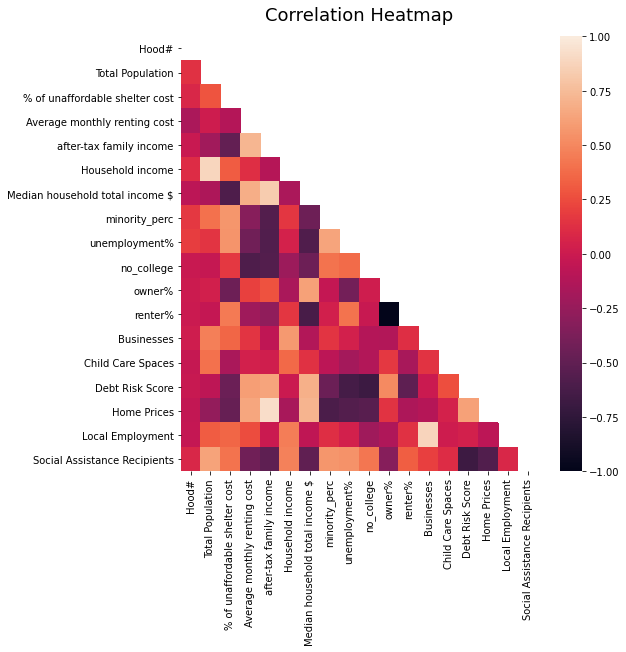

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
mask = np.triu(np.ones_like(df_heatmap.corr(), dtype=np.bool))

plt.figure(figsize=(8,8))

heatmap = sns.heatmap(df_heatmap.corr(), mask=mask, vmin=-1, vmax=1)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

# plt.xticks(rotation=60)

In [ ]:
df_eco.head()

,Unnamed: 0,Hood#,Total Population,% of owner households spending 30% or more of household total income on shelter costs,Average monthly shelter costs for rented dwellings ($),Average after-tax family income $ (Family income in 2010 of economic families),Household income in 2010 of private households,Median household total income $,minority_perc,South Asian%,Chinese%,Black%,west_asian%,latin_american%,unemployment%,no_college,owner%,renter%,Neighbourhood,Businesses,Child Care Spaces,Debt Risk Score,Home Prices,Local Employment,Social Assistance Recipients
0,0,1,34100,27.9,945,72820,10130,66241,0.776393,0.383578,0.020381,0.187243,0.006452,0.035777,0.051320,0.180938,0.698765,0.301235,West Humber-Clairville,2463,195,719,317508.0,58271,2912
1,1,2,32790,33.3,921,57411,9610,49934,0.859256,0.387923,0.006099,0.252668,0.035377,0.026532,0.066331,0.209058,0.472425,0.527575,Mount Olive-Silverstone-Jamestown,271,60,687,251119.0,3244,6561
2,2,3,10140,25.1,887,70838,3225,62042,0.619822,0.225345,0.010355,0.150888,0.028107,0.066075,0.052268,0.194280,0.644961,0.355039,Thistletown-Beaumond Heights,217,25,718,414216.0,1311,1276
3,3,4,10485,19.7,857,69367,3945,56545,0.422031,0.136862,0.019075,0.097759,0.003815,0.061993,0.056271,0.199809,0.509506,0.490494,Rexdale-Kipling,144,75,721,392271.0,1178,1323
4,4,5,9550,34.3,966,61196,3225,50846,0.576963,0.096859,0.012565,0.225131,0.027749,0.072775,0.060209,0.212042,0.592248,0.407752,Elms-Old Rexdale,67,60,692,233832.0,903,1683


In [ ]:
#merge two tables and drop uesless columns
data = df_merged.merge(df_eco, how='left', left_on='hoodId', right_on='Hood#')
data.drop(columns=['location', 'city', 'Unnamed: 0_y','Unnamed: 0_x', 'price','Latitude','Longitude'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216 entries, 0 to 1215
Data columns (total 41 columns):
 #   Column                                                                                 Non-Null Count  Dtype  
---  ------                                                                                 --------------  -----  
 0   id                                                                                     1216 non-null   float64
 1   square-footage-min                                                                     1216 non-null   object 
 2   square-footage-max                                                                     1216 non-null   object 
 3   bedrooms                                                                               1216 non-null   object 
 4   bathrooms                                                                              1216 non-null   object 
 5   postal-code                                                                 

In [ ]:
check = data.loc[data['Hood#'].isnull()]
check.head()

,id,square-footage-min,square-footage-max,bedrooms,bathrooms,postal-code,unit-number,street-number,street-name,sold-price,style-name,lon,lat,area-code,Postal Code,hoods,hoodId,Hood#,Total Population,% of owner households spending 30% or more of household total income on shelter costs,Average monthly shelter costs for rented dwellings ($),Average after-tax family income $ (Family income in 2010 of economic families),Household income in 2010 of private households,Median household total income $,minority_perc,South Asian%,Chinese%,Black%,west_asian%,latin_american%,unemployment%,no_college,owner%,renter%,Neighbourhood,Businesses,Child Care Spaces,Debt Risk Score,Home Prices,Local Employment,Social Assistance Recipients
113,10852831.0,1800,1999,4,2,M3N2J8,18,2901,Jane St,480000.0,townhouse,-79.515325,43.752120,M3N,M3N,Black Creek,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,10836503.0,none,none,3,2,M3N2B6,NaN,65,Picaro Dr,860000.0,house-semidetached,-79.520620,43.754990,M3N,M3N,Black Creek,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,10834080.0,1400,1599,4,3,M3N1K3,106,19,London Green Crt,533500.0,townhouse,-79.511384,43.753300,M3N,M3N,Black Creek,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,10756778.0,none,none,2,2,M3N1L6,NaN,113,Topcliff Ave,800000.0,house-semidetached,-79.511929,43.755480,M3N,M3N,Black Creek,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,10751779.0,none,none,3,2,M3N2G9,NaN,99,Gosford Blvd,860000.0,house-detached,-79.522515,43.768005,M3N,M3N,Black Creek,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.to_csv(folder+'housing_data.csv')